In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import numpy as np
import os
import random
import torch
import torchvision
import torchvision.transforms as transform
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import argparse
import torch.optim as optim
import time
from tqdm.auto import tqdm
import matplotlib

In [3]:
labels = ['dandelion', 'daisy','tulip','sunflower','rose']
img_size = 224
train_transform = transform.Compose([
    transform.Resize((img_size, img_size)),
    transform.ToTensor()])
train_dataset = ImageFolder('./input/ee379v-hw4/train', transform=train_transform)

In [5]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
# batch size
BATCH_SIZE = 64

In [6]:
train_dataset, valid_dataset = train_test_split(train_dataset, test_size=0.1, shuffle=True, random_state=42)
# training data loaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, pin_memory=True
)
# validation data loaders
valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, pin_memory=True
)

In [13]:
matplotlib.style.use('ggplot')
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, './model.pth')

In [17]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('./accuracy.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./loss.png')

In [9]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 5)
        
        self.fc1 = nn.Linear(256, 10)
        
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        # print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        bs, _, _, _ = x.shape
        # print(x.shape)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        # print(x.shape)
        x = self.fc1(x)
        return x

In [10]:
lr = 1e-3
epochs = 20
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")
model = CNNModel().to(device)
print(model)
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss function
criterion = nn.CrossEntropyLoss()

Computation device: cpu

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
949,578 total parameters.
949,578 training parameters.


In [11]:
# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = torch.tensor(image).to(device)
        labels = torch.tensor(labels).to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

# validation
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = torch.tensor(image).to(device)
            labels = torch.tensor(labels).to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [12]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                              optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                 criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    time.sleep(5)
    
# save the trained model weights
save_model(epochs, model, optimizer, criterion)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

[INFO]: Epoch 1 of 20
Training


  0%|          | 0/55 [00:00<?, ?it/s]C:\Users\aleji\AppData\Local\Temp/ipykernel_11124/2112766141.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).to(device)
C:\Users\aleji\AppData\Local\Temp/ipykernel_11124/2112766141.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
100%|██████████| 55/55 [04:18<00:00,  4.69s/it]


Validation


  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\aleji\AppData\Local\Temp/ipykernel_11124/2112766141.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).to(device)
C:\Users\aleji\AppData\Local\Temp/ipykernel_11124/2112766141.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Training loss: 1.440, training acc: 34.279
Validation loss: 1.432, validation acc: 39.691
--------------------------------------------------
[INFO]: Epoch 2 of 20
Training


100%|██████████| 55/55 [03:59<00:00,  4.35s/it]


Validation


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Training loss: 1.258, training acc: 41.874
Validation loss: 1.284, validation acc: 46.907
--------------------------------------------------
[INFO]: Epoch 3 of 20
Training


100%|██████████| 55/55 [03:52<00:00,  4.22s/it]


Validation


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Training loss: 1.185, training acc: 46.575
Validation loss: 1.172, validation acc: 50.000
--------------------------------------------------
[INFO]: Epoch 4 of 20
Training


100%|██████████| 55/55 [03:54<00:00,  4.27s/it]


Validation


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Training loss: 1.104, training acc: 54.514
Validation loss: 1.215, validation acc: 57.216
--------------------------------------------------
[INFO]: Epoch 5 of 20
Training


100%|██████████| 55/55 [03:52<00:00,  4.23s/it]


Validation


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Training loss: 1.074, training acc: 56.119
Validation loss: 1.153, validation acc: 59.794
--------------------------------------------------
[INFO]: Epoch 6 of 20
Training


100%|██████████| 55/55 [03:39<00:00,  3.99s/it]


Validation


100%|██████████| 7/7 [00:10<00:00,  1.53s/it]


Training loss: 1.031, training acc: 59.157
Validation loss: 1.054, validation acc: 64.175
--------------------------------------------------
[INFO]: Epoch 7 of 20
Training


100%|██████████| 55/55 [03:36<00:00,  3.93s/it]


Validation


100%|██████████| 7/7 [00:10<00:00,  1.55s/it]


Training loss: 1.010, training acc: 60.361
Validation loss: 1.099, validation acc: 58.505
--------------------------------------------------
[INFO]: Epoch 8 of 20
Training


100%|██████████| 55/55 [03:37<00:00,  3.95s/it]


Validation


100%|██████████| 7/7 [00:10<00:00,  1.55s/it]


Training loss: 0.960, training acc: 61.164
Validation loss: 0.981, validation acc: 64.691
--------------------------------------------------
[INFO]: Epoch 9 of 20
Training


100%|██████████| 55/55 [03:37<00:00,  3.95s/it]


Validation


100%|██████████| 7/7 [00:11<00:00,  1.58s/it]


Training loss: 0.925, training acc: 63.199
Validation loss: 0.908, validation acc: 66.237
--------------------------------------------------
[INFO]: Epoch 10 of 20
Training


100%|██████████| 55/55 [03:37<00:00,  3.96s/it]


Validation


100%|██████████| 7/7 [00:10<00:00,  1.55s/it]


Training loss: 0.916, training acc: 63.915
Validation loss: 0.944, validation acc: 64.691
--------------------------------------------------
[INFO]: Epoch 11 of 20
Training


100%|██████████| 55/55 [03:36<00:00,  3.94s/it]


Validation


100%|██████████| 7/7 [00:10<00:00,  1.54s/it]


Training loss: 0.857, training acc: 66.925
Validation loss: 0.996, validation acc: 63.402
--------------------------------------------------
[INFO]: Epoch 12 of 20
Training


100%|██████████| 55/55 [03:34<00:00,  3.91s/it]


Validation


100%|██████████| 7/7 [00:10<00:00,  1.50s/it]


Training loss: 0.853, training acc: 67.297
Validation loss: 0.880, validation acc: 69.588
--------------------------------------------------
[INFO]: Epoch 13 of 20
Training


100%|██████████| 55/55 [03:32<00:00,  3.87s/it]


Validation


100%|██████████| 7/7 [00:10<00:00,  1.51s/it]


Training loss: 0.829, training acc: 68.472
Validation loss: 0.893, validation acc: 66.237
--------------------------------------------------
[INFO]: Epoch 14 of 20
Training


100%|██████████| 55/55 [03:31<00:00,  3.85s/it]


Validation


100%|██████████| 7/7 [00:10<00:00,  1.52s/it]


Training loss: 0.827, training acc: 68.501
Validation loss: 0.824, validation acc: 70.619
--------------------------------------------------
[INFO]: Epoch 15 of 20
Training


100%|██████████| 55/55 [03:31<00:00,  3.85s/it]


Validation


100%|██████████| 7/7 [00:10<00:00,  1.49s/it]


Training loss: 0.793, training acc: 70.364
Validation loss: 0.981, validation acc: 67.784
--------------------------------------------------
[INFO]: Epoch 16 of 20
Training


100%|██████████| 55/55 [03:30<00:00,  3.83s/it]


Validation


100%|██████████| 7/7 [00:10<00:00,  1.50s/it]


Training loss: 0.797, training acc: 69.275
Validation loss: 0.806, validation acc: 71.649
--------------------------------------------------
[INFO]: Epoch 17 of 20
Training


100%|██████████| 55/55 [03:33<00:00,  3.89s/it]


Validation


100%|██████████| 7/7 [00:10<00:00,  1.54s/it]


Training loss: 0.753, training acc: 72.026
Validation loss: 0.830, validation acc: 70.361
--------------------------------------------------
[INFO]: Epoch 18 of 20
Training


100%|██████████| 55/55 [03:56<00:00,  4.30s/it]


Validation


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Training loss: 0.751, training acc: 71.826
Validation loss: 0.884, validation acc: 67.268
--------------------------------------------------
[INFO]: Epoch 19 of 20
Training


100%|██████████| 55/55 [03:58<00:00,  4.33s/it]


Validation


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Training loss: 0.728, training acc: 72.915
Validation loss: 0.799, validation acc: 72.423
--------------------------------------------------
[INFO]: Epoch 20 of 20
Training


100%|██████████| 55/55 [03:56<00:00,  4.30s/it]


Validation


100%|██████████| 7/7 [00:11<00:00,  1.69s/it]


Training loss: 0.738, training acc: 71.912
Validation loss: 0.860, validation acc: 73.454
--------------------------------------------------


FileNotFoundError: [Errno 2] No such file or directory: 'outputs/model.pth'

TRAINING COMPLETE


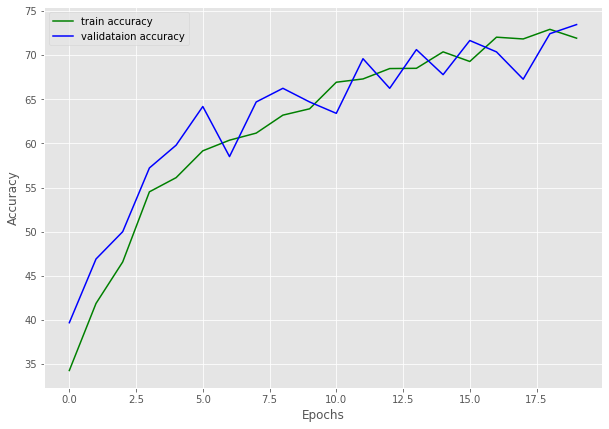

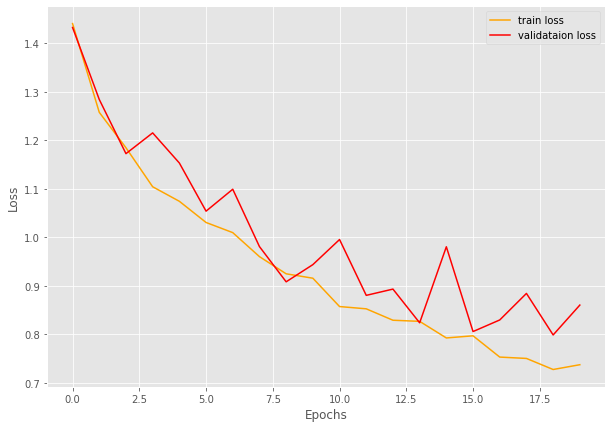

In [18]:
# save the trained model weights
save_model(epochs, model, optimizer, criterion)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

In [78]:
import copy
model2 = CNNModel()
model2.load_state_dict(copy.deepcopy(torch.load('model.pth', device)['model_state_dict']))

test_dataset = ImageFolder('./input/ee379v-hw4/test', transform=train_transform)
test_loader = DataLoader(
  test_dataset, batch_size = BATCH_SIZE,
  num_workers=4, pin_memory=True
)
preds = []
for i, (data, _) in enumerate(test_loader):
  outputs = model2(data)
  _, pred = torch.max(outputs.data, 1)
  # fnames = test_loader.dataset.samples[i]
  # print(fnames)
  preds.append(pred)
# print(preds)


In [79]:
list_preds = []
for batch in preds:
  for pred in batch:
    list_preds.append(int(pred))
# print(list_preds)

In [62]:
import glob
file_names = glob.glob("./input/ee379v-hw4/test/test/*")
file_names = [os.path.basename(x) for x in file_names]
# print((file_names))

In [63]:
import pandas as pd
label_preds = []
for pred in list_preds:
  label_preds.append(labels[pred])
sub_preds = pd.DataFrame(label_preds)
sub_preds["Id"] = file_names
sub_preds.rename(columns = {0:'Category'}, inplace = True)
columns_titles = ["Id","Category"]
sub_preds=sub_preds.reindex(columns=columns_titles)
sub_preds.to_csv('flower_preds.csv', index=False)

In [76]:
# print(os.listdir("./input/ee379v-hw4/test/test/"))